In [1]:
import requests
from math import floor, log10
import pandas as pd
import geopandas as gpd
from pystac_client import Client
import planetary_computer as pc
import numpy as np
import rasterio
import requests, pyproj
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
import rasterio
from rasterio.plot import show
from rasterio.merge import merge as rmerge
from rasterio import transform as rtransform
import rasterio.mask
from rasterio.features import shapes
from shapely.geometry import Polygon, MultiPolygon, box, shape
from shapely.ops import transform, unary_union
from matplotlib import pyplot as plt

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
MIN_PATCHSIZE = 10000    # Min patch size to be included in analysis (sq meter)
CONNECTED_MAXDIST = 100

**City boundaries**

In [4]:
# Get Addis boundary
aws_s3_dir = "https://cities-cities4forests.s3.eu-west-3.amazonaws.com/data"
boundary_georef = pd.read_csv('https://cities-cities4forests.s3.eu-west-3.amazonaws.com/data/boundaries/v_0/boundary_georef.csv')
boundary_id_aoi = boundary_georef.loc[5, 'geo_name']+'-'+boundary_georef.loc[5, 'aoi_boundary_name']
print("\n boundary_id_aoi: " + boundary_id_aoi)
# read boundaries
boundary_path = aws_s3_dir +'/boundaries/v_0/boundary-'+ boundary_id_aoi +'.geojson'
boundary_geo = requests.get(boundary_path).json()
addis_gdf = gpd.GeoDataFrame.from_features(boundary_geo)


 boundary_id_aoi: ETH-Addis_Ababa-ADM4union


In [5]:
# Get Kigali boundary
aws_s3_dir = "https://cities-urbanshift.s3.eu-west-3.amazonaws.com/data"
boundary_georef = pd.read_csv('https://cities-urbanshift.s3.eu-west-3.amazonaws.com/data/boundaries/v_0/boundary_georef.csv')
boundary_id_aoi = boundary_georef.loc[14, 'geo_name']+'-'+boundary_georef.loc[14, 'aoi_boundary_name']
print("\n boundary_id_aoi: " + boundary_id_aoi)
# read boundaries
boundary_path = aws_s3_dir +'/boundaries/v_0/boundary-'+ boundary_id_aoi +'.geojson'
boundary_geo = requests.get(boundary_path).json()
kigali_gdf = gpd.GeoDataFrame.from_features(boundary_geo)


 boundary_id_aoi: RWA-Kigali-ADM4union


In [6]:
boundaries = gpd.GeoDataFrame(geometry=[addis_gdf.iloc[0]['geometry'],kigali_gdf.iloc[0]['geometry']])
boundaries['city_name'] = ['Addis_Ababa', 'Kigali']
boundaries = boundaries.set_crs('EPSG:4326')

In [7]:
boundaries

,geometry,city_name
0,"MULTIPOLYGON (((38.74353 8.90096, 38.74353 8.9...",Addis_Ababa
1,"MULTIPOLYGON (((30.02060 -2.07345, 30.01977 -2...",Kigali


**Land use rasters**

In [8]:
# This function clips and masks raster
# Adapted from https://gis.stackexchange.com/a/387772

def mask_raster_with_geometry(raster, transform, shapes, **kwargs):
    """Wrapper for rasterio.mask.mask to allow for in-memory processing.

    Docs: https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html

    Args:
        raster (numpy.ndarray): raster to be masked with dim: [H, W]
        transform (affine.Affine): the transform of the raster
        shapes, **kwargs: passed to rasterio.mask.mask

    Returns:
        masked: numpy.ndarray or numpy.ma.MaskedArray with dim: [H, W], and new affine transform
    """
    with rasterio.io.MemoryFile() as memfile:
        with memfile.open(
            driver='GTiff',
            height=raster.shape[0],
            width=raster.shape[1],
            count=1,
            dtype=raster.dtype,
            transform=transform,
        ) as dataset:
            dataset.write(raster, 1)
        with memfile.open() as dataset:
            output, new_transform = rasterio.mask.mask(dataset, shapes, **kwargs)
    return output.squeeze(0), new_transform

In [9]:
# Reclassify from ESA WorldCover classes to habitat/nonhabitat

def classify_habitat(r):  # Note: order is important
    r[r == 60] = 1    # sparse veg
    r[r >= 90] = 1    # herbaceous wetland, mangrove, lichen & moss
    r[r == 80] = 0    # permanent open water
    r[r == 70] = 0    # snow/ice
    r[r == 40] = 0    # cropland
    r[r == 50] = 0    # built up
    r[r == 30] = 1    # grassland
    r[r == 20] = 1    # shrubland
    r[r == 10] = 1    # tree cover
    r[r == 0] = 0     # no data

    return r

In [10]:
def within_distance(rownum, gdf, sidx):
    if rownum % 1000 == 0:
        print('     {0} / {1}'.format(rownum, gdf.count().geometry))
    z = list(sidx.intersection(gdf.iloc[rownum].geometry.buffer(CONNECTIVITY_DISTANCE).bounds))
    distances = gdf.iloc[z].distance(gdf.iloc[rownum].geometry)
    return [i for i in z if distances[i] <= CONNECTIVITY_DISTANCE if i != rownum]

In [11]:
def do_one_geom(row):
    geom = row['geometry']
    cityname = row['city_name']
    if type(geom) == MultiPolygon:
        district_poly = MultiPolygon(geom)
    else:
        district_poly = MultiPolygon([geom])
    bounds = district_poly.bounds
    centroid_lon = district_poly.centroid.xy[0][0]
    centroid_lat = district_poly.centroid.xy[1][0]
    target_epsg = (32600 + [0, 100][int(centroid_lat < 0)]) + floor((180 + centroid_lon) / 6) + 1
    # EPSG is 32600 (or 32700 if lat is neg) + longitude zone. Each zone is six degrees, and first zone is 1.
    # Transform from EPSG:4326 to target EPSG

    project = pyproj.Transformer.from_crs(
        pyproj.CRS.from_epsg(4326), # source coordinate system
        pyproj.CRS.from_epsg(target_epsg), # destination coordinate system
        always_xy=True
    )
    # Get ESA WorldCover raster tiles covering AOI
    catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = catalog.search(
        collections=["esa-worldcover"],
        bbox=bounds,
    )
    items = list(search.get_items())
    rasters_to_mosaic = []
    signed_hrefs = [pc.sign(i.assets["map"].href) for i in items]
    for href in signed_hrefs:
        raster = rasterio.open(href)
        rasters_to_mosaic.append(raster)

    # Stitch rasters together
    mosaic, mosaic_transform = rmerge(rasters_to_mosaic)
    # Clip raster to district boundary
    clipped_raster, clip_transform = mask_raster_with_geometry(mosaic[0], mosaic_transform, district_poly, crop=True)
    # Classify clipped raster as habitat/nonhabitat
    hab_raster = classify_habitat(clipped_raster)
    # Vectorize and collect only the habitat patches (as opposed to nonhabitat)
    with rasterio.Env():
        image = hab_raster
        results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for (s, v) 
        in shapes(image, transform=clip_transform))

    shapelist = [j for j in results if j['properties']['raster_val'] == 1]
    #all_patches = [  # project to UTM so that spatial unit is meter
    #    transform(project.transform, unary_union([Polygon(j) for j in shapelist[i]['geometry']['coordinates']])) for i in range(len(shapelist))
    #]
    patchgeoms_list = [shape(k['geometry']) for k in shapelist]
    lonlat_patches = gpd.GeoDataFrame(geometry=patchgeoms_list, crs='EPSG:4326', index=range(len(patchgeoms_list)))
    patchgeoms_utm = gpd.GeoDataFrame(geometry=lonlat_patches.to_crs(target_epsg)['geometry'])
    #patches = [
        #i for i in [j.simplify(1, preserve_topology=False) for j in all_patches] if i.area >= MIN_PATCHSIZE # Remove very small patches from consideration
    #    i for i in all_patches if i.area >= MIN_PATCHSIZE # Remove very small patches from consideration
    #]
    #patchgeoms_utm = gpd.GeoDataFrame(geometry=patches, crs='EPSG:{}'.format(target_epsg), index=range(len(patches)))
    largepatchgeoms_utm = patchgeoms_utm[patchgeoms_utm.area >= MIN_PATCHSIZE]
    buffpatchgeoms_utm = gpd.GeoDataFrame(geometry=largepatchgeoms_utm.buffer(CONNECTED_MAXDIST))
    buffergeoms_utm = gpd.GeoDataFrame(geometry=buffpatchgeoms_utm.difference(largepatchgeoms_utm['geometry']))
    buffergeoms_lonlat = gpd.GeoDataFrame(geometry=buffergeoms_utm.to_crs(4326)['geometry'])
    buffergeoms_lonlat['logarea'] = [log10(x) for x in buffergeoms_utm.area]  # Add area column. Note: units are sq m, not sq degs.

    # Add together rasters of each buffer
    rawscore = np.zeros(shape=hab_raster.shape, dtype=np.int8)
    print(cityname)
    print('raw scores')
    for i in range(len(buffergeoms_lonlat)):
        if i % 1000 == 0:
            print('{0} patches of {1}'.format(i, len(buffergeoms_lonlat)))
        rawscore += rasterio.features.rasterize([buffergeoms_lonlat.iloc[i]['geometry']], default_value=1, transform=clip_transform, out_shape = hab_raster.shape)
    print('RAW SCORE')
    show(rawscore)
    bridges = rawscore * np.greater(rawscore, 1)

    # Logarea-based score
    print('BRIDGES')
    show(bridges)

    logscore = np.zeros(shape=hab_raster.shape, dtype=np.float32)
    print('log-based scores')
    for i in range(len(buffergeoms_lonlat)):
        if i % 1000 == 0:
            print('{0} patches of {1}'.format(i, len(buffergeoms_lonlat)))
        logscore += rasterio.features.rasterize([(buffergeoms_lonlat.iloc[i]['geometry'], buffergeoms_lonlat.iloc[i]['logarea'])], transform=clip_transform, out_shape = hab_raster.shape)
    print('LOGSCORE (incl. non-bridges)')
    show(logscore)

    result = logscore * bridges
    
    print('LOGSCORE (bridges only)')
    show(result)
    print(np.histogram(result))

    # Save running sum to geotiff
    meta = {
        'driver': 'GTiff',
        'dtype': 'float32',
        'nodata': None,
        'width': hab_raster.shape[1],
        'height': hab_raster.shape[0],
        'count': 1,
        'crs': 'EPSG:4326',
        'transform': clip_transform,
        'tiled': False,
        'interleave': 'band'
    }
    with rasterio.open('{0}_connectivitypriority_v6.tif'.format(cityname), 'w', **meta) as dst:
        dst.write(result, indexes=1)

Addis_Ababa
raw scores
0 patches of 2448
1000 patches of 2448
2000 patches of 2448
RAW SCORE


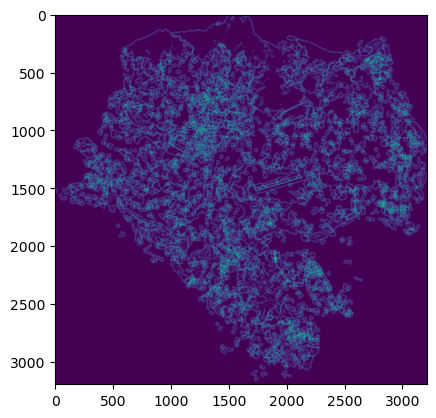

BRIDGES


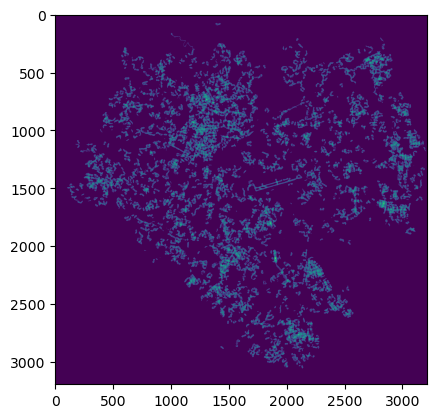

log-based scores
0 patches of 2448
1000 patches of 2448
2000 patches of 2448
LOGSCORE (incl. non-bridges)


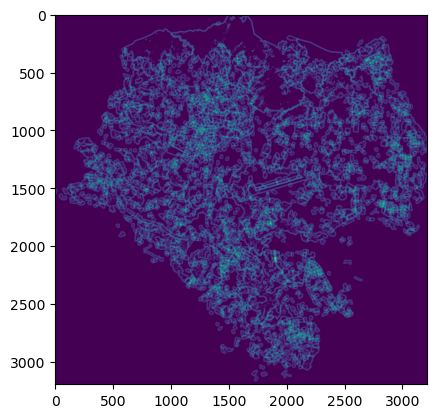

LOGSCORE (bridges only)


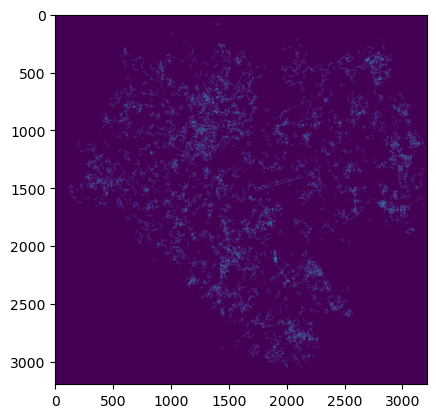

(array([9996644,  191360,   32555,   32287,       0,    2925,       0,
           112,      49,       2]), array([  0.      ,  24.235128,  48.470257,  72.70538 ,  96.94051 ,
       121.175644, 145.41077 , 169.6459  , 193.88103 , 218.11617 ,
       242.35129 ], dtype=float32))
Kigali
raw scores
0 patches of 1199
1000 patches of 1199
RAW SCORE


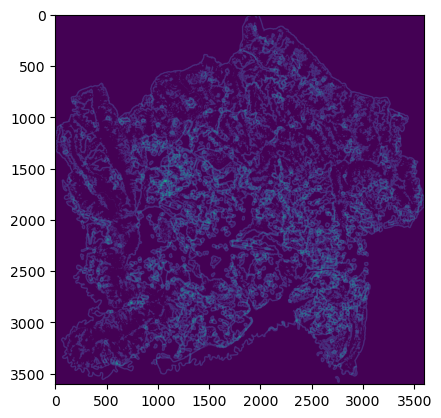

BRIDGES


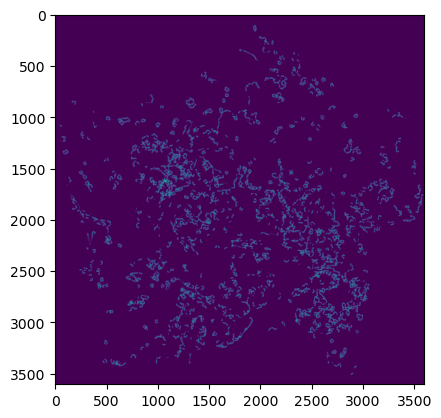

log-based scores
0 patches of 1199
1000 patches of 1199
LOGSCORE (incl. non-bridges)


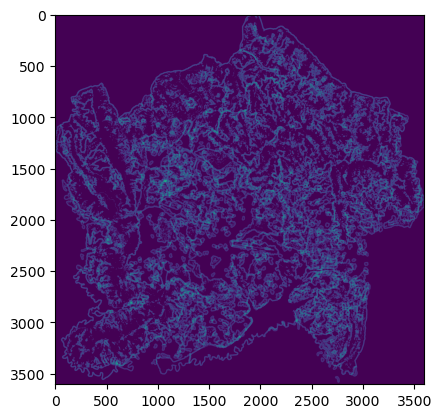

LOGSCORE (bridges only)


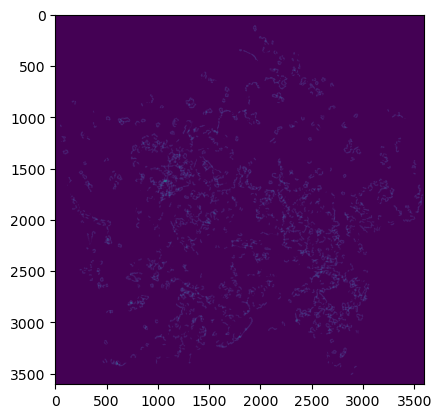

(array([12697958,   240401,    18900,     2541,        3,      150,
              0,       28,        0,        3]), array([  0.      ,  25.525845,  51.05169 ,  76.57754 , 102.10338 ,
       127.62923 , 153.15508 , 178.68092 , 204.20676 , 229.7326  ,
       255.25845 ], dtype=float32))


In [12]:
for i in range(len(boundaries)):
    do_one_geom(boundaries.iloc[i])